In [1]:
import pandas as pd 
import numpy as np

In [2]:
dtrain = pd.read_csv('train_data.csv')
dtrain.columns =['Image 1', 'Image 2', 'Forgery']
dtrain

,Image 1,Image 2,Forgery
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1
...,...,...,...
23200,031/02_031.png,031/03_031.png,0
23201,031/02_031.png,031/12_031.png,0
23202,031/02_031.png,031/11_031.png,0
23203,031/02_031.png,031/06_031.png,0


In [3]:
dtest = pd.read_csv('test_data.csv')
dtest.columns =['Image 1', 'Image 2', 'Forgery']
dtest

,Image 1,Image 2,Forgery
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1
...,...,...,...
5742,066/01_066.png,066/06_066.png,0
5743,066/01_066.png,066/08_066.png,0
5744,066/01_066.png,066/02_066.png,0
5745,066/01_066.png,066/05_066.png,0


In [4]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage
from skimage.measure import regionprops
from skimage import io
from skimage.filters import threshold_otsu   # For finding the threshold for grayscale to binary conversion
import tensorflow as tf
import pandas as pd
import numpy as np
from time import time
import keras

Using TensorFlow backend.


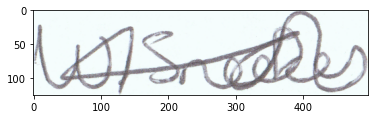

In [5]:
path = './train/' + '068/09_068.png'

img = mpimg.imread(path)

plt.imshow(img)
plt.show()

In [16]:
from skimage.color import rgb2gray

def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
#     img = ndimage.binary_erosion(img).astype(img.dtype)
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

def preproc(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    if display:
        plt.imshow(img)
        plt.show()
    grey = rgb2gray(img) #rgb to grey
    if display:
        plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
        plt.show()
    binimg = greybin(grey) #grey to binary
    if display:
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    r, c = np.where(binimg==1)
    # Now we will make a bounding box with the boundary as the position of pixels on extreme.
    # Thus we will get a cropped image with only the signature part.
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    return signimg

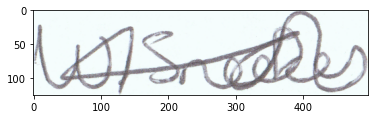

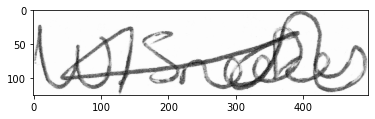

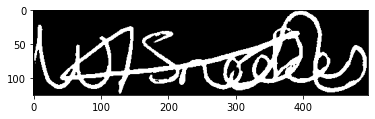

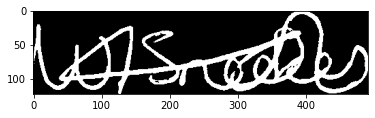

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [17]:
preproc(path)

In [23]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [24]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

In [25]:
def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

In [26]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))
    
    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

In [72]:
train = pd.DataFrame(columns= ['r1','c1','e1','so1','s1','k1','r2','c2','e2','so2','s2','k2','f'])
train

,r1,c1,e1,so1,s1,k1,r2,c2,e2,so2,s2,k2,f


In [76]:
for i in dtrain.index:
    path = './train/' + dtrain['Image 1'][i]
    img = preproc(path,None,False)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    
    path2 = './train/' + dtrain['Image 2'][i]
    img2 = preproc(path2,None,False)
    ratio2 = Ratio(img2)
    centroid2 = Centroid(img2)
    eccentricity2, solidity2 = EccentricitySolidity(img2)
    skewness2, kurtosis2 = SkewKurtosis(img2)
    
    forge = dtrain['Forgery'][i]
    print(forge)
    
    
    row = {'r1': ratio, 'c1': centroid, 'e1': eccentricity,'so1':solidity,'s1':skewness,'k1':kurtosis,
           'r2': ratio2, 'c2': centroid2, 'e2': eccentricity2,'so2':solidity2,'s2':skewness2,'k2':kurtosis2,
           'f':forge}
    
    train = train.append(row,ignore_index = True)
    if i==3:
        print('\n\n',train.head())
    print(i,end=',')
train.head()

1
0,1
1,1
2,1


          r1                                        c1        e1       so1  \
0  0.208333  (0.6252338408898735, 0.5325170744710246)  0.981067  0.243212   
1  0.208333  (0.6252338408898735, 0.5325170744710246)  0.981067  0.243212   
2  0.208333  (0.6252338408898735, 0.5325170744710246)  0.981067  0.243212   
3  0.208333  (0.6252338408898735, 0.5325170744710246)  0.981067  0.243212   

                                           s1  \
0  (-0.2607245559907364, -0.6425385970478982)   
1  (-0.2607245559907364, -0.6425385970478982)   
2  (-0.2607245559907364, -0.6425385970478982)   
3  (-0.2607245559907364, -0.6425385970478982)   

                                           k1        r2  \
0  (-1.1699344476355247, -0.3074306786941148)  0.171436   
1  (-1.1699344476355247, -0.3074306786941148)  0.155018   
2  (-1.1699344476355247, -0.3074306786941148)  0.138833   
3  (-1.1699344476355247, -0.3074306786941148)  0.155300   

                                         c2        e2  

KeyboardInterrupt: 

In [77]:
train

,r1,c1,e1,so1,s1,k1,r2,c2,e2,so2,s2,k2,f
0,0.208333,"(0.6252338408898735, 0.5325170744710246)",0.981067,0.243212,"(-0.2607245559907364, -0.6425385970478982)","(-1.1699344476355247, -0.3074306786941148)",0.171436,"(0.44858795195508444, 0.519045633815288)",0.963608,0.222913,"(-0.10471716033887267, 0.009542628566497048)","(-1.1841018905904555, -0.19080659097951447)",1
1,0.208333,"(0.6252338408898735, 0.5325170744710246)",0.981067,0.243212,"(-0.2607245559907364, -0.6425385970478982)","(-1.1699344476355247, -0.3074306786941148)",0.155018,"(0.4936764807798111, 0.5531240570843791)",0.978196,0.196333,"(-0.2186031640313443, -0.38247806826842273)","(-1.2751823015916763, -0.645805689467847)",1
2,0.208333,"(0.6252338408898735, 0.5325170744710246)",0.981067,0.243212,"(-0.2607245559907364, -0.6425385970478982)","(-1.1699344476355247, -0.3074306786941148)",0.138833,"(0.5551472369565569, 0.5469301369095725)",0.976092,0.183620,"(-0.3722446972694968, -0.3570540759042535)","(-1.2471849093342366, -0.16567846778048523)",1
3,0.208333,"(0.6252338408898735, 0.5325170744710246)",0.981067,0.243212,"(-0.2607245559907364, -0.6425385970478982)","(-1.1699344476355247, -0.3074306786941148)",0.155300,"(0.4298010393237705, 0.5421431311710427)",0.973192,0.188445,"(-0.17716615238034447, 0.060672613331536646)","(-1.2488355716420871, -0.5667942757809716)",1
4,0.208333,"(0.6252338408898735, 0.5325170744710246)",0.981067,0.243212,"(-0.2607245559907364, -0.6425385970478982)","(-1.1699344476355247, -0.3074306786941148)",0.102185,"(0.5247294736625338, 0.5535204009085837)",0.974272,0.136366,"(-0.2967739024623295, -0.05886735069783738)","(-1.3411761975123957, -0.2072658065910864)",1
5,0.208333,"(0.6252338408898735, 0.5325170744710246)",0.981067,0.243212,"(-0.2607245559907364, -0.6425385970478982)","(-1.1699344476355247, -0.3074306786941148)",0.121966,"(0.5390358794220618, 0.5296572596190916)",0.977360,0.164004,"(-0.1863001928155029, -0.13568799316718494)","(-1.2863698058636241, -0.14094623174293108)",1
6,0.208333,"(0.6252338408898735, 0.5325170744710246)",0.981067,0.243212,"(-0.2607245559907364, -0.6425385970478982)","(-1.1699344476355247, -0.3074306786941148)",0.177196,"(0.5037684681024984, 0.5567488548351427)",0.967854,0.212800,"(-0.19291975083409396, -0.2099687100486226)","(-1.2218136709097205, -0.601400375924177)",1
7,0.186145,"(0.5855906455338956, 0.5406364047143081)",0.984181,0.237335,"(-0.3686819317686999, -0.8056757388257261)","(-1.2242927158433783, 0.0809644258944826)",0.095973,"(0.49288436134326374, 0.557740100187746)",0.979299,0.133151,"(-0.17976750686324167, 0.03145238113901765)","(-1.2928560420179454, -0.3590955084585432)",1
8,0.186145,"(0.5855906455338956, 0.5406364047143081)",0.984181,0.237335,"(-0.3686819317686999, -0.8056757388257261)","(-1.2242927158433783, 0.0809644258944826)",0.171436,"(0.44858795195508444, 0.519045633815288)",0.963608,0.222913,"(-0.10471716033887267, 0.009542628566497048)","(-1.1841018905904555, -0.19080659097951447)",1
9,0.186145,"(0.5855906455338956, 0.5406364047143081)",0.984181,0.237335,"(-0.3686819317686999, -0.8056757388257261)","(-1.2242927158433783, 0.0809644258944826)",0.155018,"(0.4936764807798111, 0.5531240570843791)",0.978196,0.196333,"(-0.2186031640313443, -0.38247806826842273)","(-1.2751823015916763, -0.645805689467847)",1
